<a href="https://colab.research.google.com/github/LinarKulinar/Data-Analysis-Tools-SSAU/blob/main/Lab_5_Catboost_6133_Akhmetov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Лабораторная работа 5**

# Градиентный бустинг с Catboost

Выполнил: 6133, Ахметов Линар

In [ ]:
import catboost
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from catboost.utils import get_roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from catboost import Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import FeatureHasher
import seaborn as sns


Данные представляет размеченый датасет с различными генетическими мутациями.

Скачать можно на [kaggle](https://www.kaggle.com/datasets/kevinarvai/clinvar-conflicting).

In [ ]:
df = pd.read_csv('clinvar_conflicting.csv', dtype={0: object, 38: str, 40: object})

In [ ]:
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,NaN,not_specified,...,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,...,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,...,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


In [ ]:
print(df.CLNVC.unique())
print(df.IMPACT.unique())
print(df.PolyPhen.unique())
print(df.SIFT.unique())
print(df.BIOTYPE.unique())

['single_nucleotide_variant' 'Deletion' 'Duplication' 'Indel' 'Inversion'
 'Insertion' 'Microsatellite']
['MODERATE' 'MODIFIER' 'LOW' 'HIGH']
['benign' 'probably_damaging' nan 'possibly_damaging' 'unknown']
['tolerated' 'deleterious_low_confidence' 'deleterious' nan
 'tolerated_low_confidence']
['protein_coding' 'misc_RNA' nan]


In [ ]:
df = df.drop(["CLNDN",'CLNDISDBINCL','MOTIF_NAME','MOTIF_POS','HIGH_INF_POS','MOTIF_SCORE_CHANGE','DISTANCE','CLNHGVS','CLNDISDB',"CLNDNINCL",'CLNSIGINCL','SSR','INTRON','Codons','MC','CLNVI','SYMBOL','Amino_acids','Protein_position','CDS_position','EXON','cDNA_position','Feature', 'Feature_type','BAM_EDIT'], axis=1)
df.BIOTYPE = df.BIOTYPE.fillna('0')

fh = FeatureHasher(n_features=10, input_type='string')
hashed_alt = pd.DataFrame(fh.fit_transform(df['ALT']).toarray()).rename(columns={0:'ALT_1',
                                                                                 1:'ALT_2',
                                                                                 2:'ALT_3',
                                                                                 3:'ALT_4', 
                                                                                 4:'ALT_5', 
                                                                                 5:'ALT_6', 
                                                                                 6:'ALT_7', 
                                                                                 7:'ALT_8', 
                                                                                 8:'ALT_9',
                                                                                 9:'ALT_10'})
df = df.drop(columns=['ALT'])
df = pd.concat([df, hashed_alt], axis=1)
fh = FeatureHasher(n_features=10, input_type='string')
hashed_ref = pd.DataFrame(fh.fit_transform(df['REF']).toarray()).rename(columns={0:'REF_1',
                                                                                 1:'REF_2',
                                                                                 2:'REF_3',
                                                                                 3:'REF_4', 
                                                                                 4:'REF_5', 
                                                                                 5:'REF_6', 
                                                                                 6:'REF_7', 
                                                                                 7:'REF_8', 
                                                                                 8:'REF_9',
                                                                                 9:'REF_10'})

df = df.drop(columns=['REF'])

df = pd.concat([df, hashed_ref], axis=1)
hashed_chrom = pd.DataFrame(fh.fit_transform(df['CHROM']).toarray()).rename(columns={0:'CHROM_1',
                                                                                     1:'CHROM_2',
                                                                                     2:'CHROM_3',
                                                                                     3:'CHROM_4', 
                                                                                     4:'CHROM_5', 
                                                                                     5:'CHROM_6',
                                                                                     6:'CHROM_7',
                                                                                     7:'CHROM_8',
                                                                                     8:'CHROM_9',
                                                                                     9:'CHROM_10'})

df = df.drop(columns=['CHROM'])

df = pd.concat([df,hashed_chrom], axis=1)
hashed_allele = pd.DataFrame(fh.fit_transform(df['Allele']).toarray()).rename(columns={0:'Allele_1',
                                                                                       1:'Allele_2',
                                                                                       2:'Allele_3',
                                                                                       3:'Allele_4', 
                                                                                       4:'Allele_5',
                                                                                       5:'Allele_6', 
                                                                                       6:'Allele_7', 
                                                                                       7:'Allele_8', 
                                                                                       8:'Allele_9', 
                                                                                       9:'Allele_10'})

df = df.drop(columns=['Allele'])

df = pd.concat([df, hashed_allele], axis=1)
hashed_consequence = pd.DataFrame(fh.fit_transform(df['Consequence']).toarray()).rename(columns={0:'Consequence_1',
                                                                                                 1:'Consequence_2',
                                                                                                 2:'Consequence_3',
                                                                                                 3:'Consequence_4',
                                                                                                 4:'Consequence_5',
                                                                                                 5:'Consequence_6',
                                                                                                 6:'Consequence_7',
                                                                                                 7:'Consequence_8',
                                                                                                 8:'Consequence_9',
                                                                                                 9:'Consequence_10'})

df = df.drop(columns=['Consequence'])

df = pd.concat([df, hashed_consequence], axis=1)
df = df.fillna(0)

In [ ]:
cat_columns = ['CLNVC', 'IMPACT', 'PolyPhen', 'SIFT', 'BIOTYPE']
for column in cat_columns:
    code, unique = pd.factorize(df[column])
    df[column] = pd.Series(code)

In [ ]:
X = df.drop(columns=['CLASS'])
y = df.CLASS

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

# 1. CatBoostClassifier
*Применить классификатор CatBoostClassifier к вашему набору данных. Обратите внимание, что catboost умеет работать с категориальными признаками (параметр cat_features - список индексов категориальных признаков), поэтому использование pd.factorize / pd.get_dummies здесь лишнее.*

In [ ]:
clf = CatBoostClassifier(iterations=1000,
                         learning_rate=0.05,  
                         eval_metric='AUC',
                         custom_loss=['AUC', 'Accuracy', 'Precision', 'Recall'],
                         cat_features=cat_columns,
                         early_stopping_rounds=5)
clf.fit(
    X_train, y_train,
    cat_features=cat_columns,
    eval_set=(X_test, y_test)
)

0:	test: 0.6845190	best: 0.6845190 (0)	total: 24.5ms	remaining: 24.5s
1:	test: 0.7138218	best: 0.7138218 (1)	total: 46.3ms	remaining: 23.1s
2:	test: 0.7176859	best: 0.7176859 (2)	total: 67.3ms	remaining: 22.4s
3:	test: 0.7219076	best: 0.7219076 (3)	total: 92.1ms	remaining: 22.9s
4:	test: 0.7251248	best: 0.7251248 (4)	total: 114ms	remaining: 22.7s
5:	test: 0.7245404	best: 0.7251248 (4)	total: 134ms	remaining: 22.2s
6:	test: 0.7276409	best: 0.7276409 (6)	total: 155ms	remaining: 21.9s
7:	test: 0.7284048	best: 0.7284048 (7)	total: 178ms	remaining: 22.1s
8:	test: 0.7288130	best: 0.7288130 (8)	total: 202ms	remaining: 22.3s
9:	test: 0.7312199	best: 0.7312199 (9)	total: 224ms	remaining: 22.2s
10:	test: 0.7334233	best: 0.7334233 (10)	total: 248ms	remaining: 22.3s
11:	test: 0.7344414	best: 0.7344414 (11)	total: 270ms	remaining: 22.3s
12:	test: 0.7348716	best: 0.7348716 (12)	total: 295ms	remaining: 22.4s
13:	test: 0.7349369	best: 0.7349369 (13)	total: 316ms	remaining: 22.3s
14:	test: 0.7355107	be

117:	test: 0.7625232	best: 0.7625232 (117)	total: 2.75s	remaining: 20.5s
118:	test: 0.7625461	best: 0.7625461 (118)	total: 2.77s	remaining: 20.6s
119:	test: 0.7628335	best: 0.7628335 (119)	total: 2.8s	remaining: 20.5s
120:	test: 0.7628712	best: 0.7628712 (120)	total: 2.82s	remaining: 20.5s
121:	test: 0.7630951	best: 0.7630951 (121)	total: 2.85s	remaining: 20.5s
122:	test: 0.7632239	best: 0.7632239 (122)	total: 2.87s	remaining: 20.4s
123:	test: 0.7634493	best: 0.7634493 (123)	total: 2.89s	remaining: 20.4s
124:	test: 0.7635676	best: 0.7635676 (124)	total: 2.91s	remaining: 20.4s
125:	test: 0.7636781	best: 0.7636781 (125)	total: 2.93s	remaining: 20.3s
126:	test: 0.7637608	best: 0.7637608 (126)	total: 2.96s	remaining: 20.3s
127:	test: 0.7638293	best: 0.7638293 (127)	total: 2.97s	remaining: 20.3s
128:	test: 0.7638224	best: 0.7638293 (127)	total: 2.99s	remaining: 20.2s
129:	test: 0.7639101	best: 0.7639101 (129)	total: 3.01s	remaining: 20.2s
130:	test: 0.7639130	best: 0.7639130 (130)	total: 3.

233:	test: 0.7697013	best: 0.7697013 (233)	total: 5.3s	remaining: 17.3s
234:	test: 0.7697536	best: 0.7697536 (234)	total: 5.32s	remaining: 17.3s
235:	test: 0.7697706	best: 0.7697706 (235)	total: 5.34s	remaining: 17.3s
236:	test: 0.7697722	best: 0.7697722 (236)	total: 5.37s	remaining: 17.3s
237:	test: 0.7697748	best: 0.7697748 (237)	total: 5.39s	remaining: 17.2s
238:	test: 0.7698485	best: 0.7698485 (238)	total: 5.41s	remaining: 17.2s
239:	test: 0.7698607	best: 0.7698607 (239)	total: 5.43s	remaining: 17.2s
240:	test: 0.7698544	best: 0.7698607 (239)	total: 5.45s	remaining: 17.2s
241:	test: 0.7698797	best: 0.7698797 (241)	total: 5.47s	remaining: 17.1s
242:	test: 0.7699742	best: 0.7699742 (242)	total: 5.49s	remaining: 17.1s
243:	test: 0.7700209	best: 0.7700209 (243)	total: 5.51s	remaining: 17.1s
244:	test: 0.7700151	best: 0.7700209 (243)	total: 5.53s	remaining: 17.1s
245:	test: 0.7699740	best: 0.7700209 (243)	total: 5.56s	remaining: 17s
246:	test: 0.7700366	best: 0.7700366 (246)	total: 5.58

347:	test: 0.7741357	best: 0.7741498 (344)	total: 7.81s	remaining: 14.6s
348:	test: 0.7741677	best: 0.7741677 (348)	total: 7.83s	remaining: 14.6s
349:	test: 0.7741589	best: 0.7741677 (348)	total: 7.86s	remaining: 14.6s
350:	test: 0.7742398	best: 0.7742398 (350)	total: 7.88s	remaining: 14.6s
351:	test: 0.7742413	best: 0.7742413 (351)	total: 7.9s	remaining: 14.5s
352:	test: 0.7742664	best: 0.7742664 (352)	total: 7.92s	remaining: 14.5s
353:	test: 0.7743043	best: 0.7743043 (353)	total: 7.93s	remaining: 14.5s
354:	test: 0.7743651	best: 0.7743651 (354)	total: 7.95s	remaining: 14.5s
355:	test: 0.7744440	best: 0.7744440 (355)	total: 7.97s	remaining: 14.4s
356:	test: 0.7744581	best: 0.7744581 (356)	total: 7.99s	remaining: 14.4s
357:	test: 0.7744979	best: 0.7744979 (357)	total: 8.02s	remaining: 14.4s
358:	test: 0.7745561	best: 0.7745561 (358)	total: 8.04s	remaining: 14.4s
359:	test: 0.7745742	best: 0.7745742 (359)	total: 8.06s	remaining: 14.3s
360:	test: 0.7746048	best: 0.7746048 (360)	total: 8.

468:	test: 0.7768392	best: 0.7768407 (467)	total: 10.3s	remaining: 11.7s
469:	test: 0.7769037	best: 0.7769037 (469)	total: 10.3s	remaining: 11.6s
470:	test: 0.7768962	best: 0.7769037 (469)	total: 10.3s	remaining: 11.6s
471:	test: 0.7769488	best: 0.7769488 (471)	total: 10.4s	remaining: 11.6s
472:	test: 0.7769909	best: 0.7769909 (472)	total: 10.4s	remaining: 11.6s
473:	test: 0.7769966	best: 0.7769966 (473)	total: 10.4s	remaining: 11.6s
474:	test: 0.7770761	best: 0.7770761 (474)	total: 10.4s	remaining: 11.5s
475:	test: 0.7771034	best: 0.7771034 (475)	total: 10.5s	remaining: 11.5s
476:	test: 0.7771101	best: 0.7771101 (476)	total: 10.5s	remaining: 11.5s
477:	test: 0.7771104	best: 0.7771104 (477)	total: 10.5s	remaining: 11.5s
478:	test: 0.7771195	best: 0.7771195 (478)	total: 10.5s	remaining: 11.4s
479:	test: 0.7771173	best: 0.7771195 (478)	total: 10.5s	remaining: 11.4s
480:	test: 0.7770437	best: 0.7771195 (478)	total: 10.6s	remaining: 11.4s
481:	test: 0.7770875	best: 0.7771195 (478)	total: 1

### Вывести итерацию с наилучшим значением AUC

In [ ]:
clf.tree_count_

479

### Вывести значения метрик качества классификации на тестовых данных (accuracy и precision / recall / AUC, если применимо)

In [ ]:
clf.best_score_['validation']

{'Recall': 0.27392900856793145,
 'Accuracy': 0.7651715039577837,
 'Logloss': 0.46766296681837377,
 'Precision': 1.0,
 'AUC': 0.7771194715473393}

# 3. Для бинарного классификатора на основе CatBoostClassifier построить кривые PRC и ROC. Вычислить значения PRC-AUC и ROC-AUC.

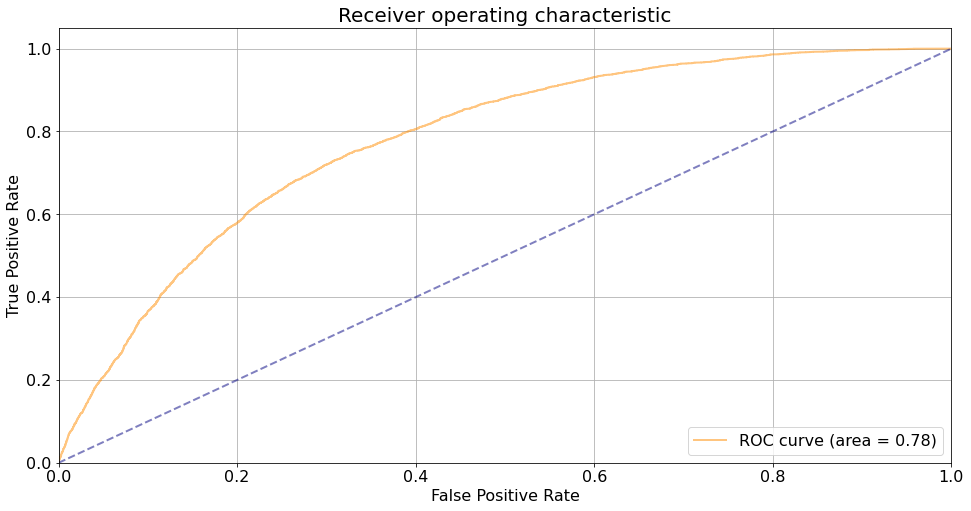

ROC_AUC: 0.7771194715473394


In [ ]:
eval_pool = Pool(X_test, y_test, cat_features=cat_columns)
fpr, tpr, thresholds = get_roc_curve(clf, eval_pool)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()
print("ROC_AUC:", roc_auc)

Text(0.5, 1.0, 'PRC curve')

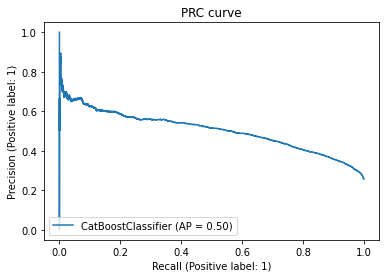

In [ ]:
disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('PRC curve')

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])

PRC_AUC = auc(recall, precision)
print("PRC_AUC:", PRC_AUC)

PRC_AUC: 0.5035333096736386


# 2. CatBoostRegressor
*Применить регрессию CatBoostRegressor к набору данных для регрессии. Вывести номер итерации и значения метрик (MAE и MSE) для наилучшей итерации. Обратите внимание, что в задаче восстановления регрессии целевая переменная имеет непрерывные значения.*

In [ ]:
penguins = sns.load_dataset('penguins')
penguins = penguins.dropna()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [ ]:
cat_columns = ['species', 'island', 'sex']
for column in cat_columns:
    code, unique = pd.factorize(penguins[column])
    penguins[column] = pd.Series(code)
    
penguins = penguins.dropna()
penguins = penguins.astype('int64')

In [ ]:
y = penguins['body_mass_g']
X = penguins.drop('body_mass_g', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
reg = CatBoostRegressor(iterations=100,
                        learning_rate=0.05,  
                        eval_metric='MAE',
                        loss_function='RMSE',
                        early_stopping_rounds=5,
                        cat_features=cat_columns)

reg.fit(X_train, y_train,
             cat_features=cat_columns,
             eval_set = (X_test, y_test)
)

0:	learn: 665.9559840	test: 567.8071243	best: 567.8071243 (0)	total: 1.05ms	remaining: 104ms
1:	learn: 641.6117076	test: 547.6891025	best: 547.6891025 (1)	total: 2.14ms	remaining: 105ms
2:	learn: 619.3335514	test: 528.3668253	best: 528.3668253 (2)	total: 3.43ms	remaining: 111ms
3:	learn: 597.1459583	test: 507.2547094	best: 507.2547094 (3)	total: 4.21ms	remaining: 101ms
4:	learn: 576.9965204	test: 489.5082491	best: 489.5082491 (4)	total: 5.08ms	remaining: 96.5ms
5:	learn: 557.7241261	test: 473.6246984	best: 473.6246984 (5)	total: 6.06ms	remaining: 94.9ms
6:	learn: 538.6168657	test: 455.8999572	best: 455.8999572 (6)	total: 6.88ms	remaining: 91.4ms
7:	learn: 521.1747690	test: 439.2740430	best: 439.2740430 (7)	total: 7.76ms	remaining: 89.2ms
8:	learn: 504.0045428	test: 425.9342242	best: 425.9342242 (8)	total: 8.63ms	remaining: 87.3ms
9:	learn: 489.2510653	test: 412.7719829	best: 412.7719829 (9)	total: 9.39ms	remaining: 84.5ms
10:	learn: 475.3739997	test: 399.8795194	best: 399.8795194 (10)	

### Вывести номер итерации с значения метрик (MAE и MSE) для наилучшей итерации. 

In [ ]:
reg.best_score_

{'learn': {'MAE': 238.93344113035147, 'RMSE': 297.37474414375265},
 'validation': {'MAE': 239.42744042144176, 'RMSE': 321.59586630512274}}

# Вывод
Для бинарной классификации было проведено сравнение по параметру accuracy с результатом прошлой лабораторной. Было получено, что CatBoostClassifier показывает практически такой же результат, что и RandomForest с параметрами: кол-во деревьев – 8, максимальная глубина дерева – 16